In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
import math
import mlflow
from mlflow.models.signature import infer_signature

In [2]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
min_max_scaler = MinMaxScaler()
standar_scaler = StandardScaler()
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng)

In [3]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

def porcentaje_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((data < BI) | (data > BS))
    print("Porcentaje de outliers: ", 100*out.sum()/out.count())

def quitar_outliers(data, df_feature):
    Q1 = df_feature.quantile(0.25)
    Q3 = df_feature.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((df_feature > BI) & (df_feature < BS))
    data = data.loc[out]
    return data

In [62]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')
df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [64]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
#Eliminar signo de interrogación de modelo y calcular valores únicos
df.Model = df.Model.apply(lambda x: x.replace('?', ''))
print("Valores únicos de modelos: ",len(df.Model.value_counts()))

Valores únicos de modelos:  319


In [66]:
#Encoder Fuel Type
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [67]:
drop_columns = ['Model', 'Id', 'Cylinders']

In [68]:
df = df.drop(columns=drop_columns)

**Matriz de Correlación**

In [69]:
correlations = df.corr()
correlations.style.background_gradient('Pastel1')

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,CNG,Diesel,Petrol
Price,1.000000,-0.876590,-0.018138,0.885159,-0.569960,0.314990,0.108905,0.033081,0.126389,0.185326,0.063104,0.219197,0.581198,0.197802,0.028133,0.146627,0.306138,0.093588,0.248974,0.429259,0.588262,0.601292,0.481374,0.343458,0.356518,0.064275,-0.041887,0.222083,0.164121,0.102569,0.108564,-0.043179,-0.172369,-0.039536,0.054084,-0.038516
Age_08_04,-0.876590,1.000000,-0.123255,-0.983661,0.505672,-0.156622,-0.108150,0.031717,-0.098084,-0.148359,-0.005364,-0.198431,-0.470253,-0.164658,0.006865,-0.152563,-0.412887,-0.105406,-0.329017,-0.403600,-0.426259,-0.719449,-0.510895,-0.279631,-0.283856,-0.069192,0.013791,-0.126895,-0.110988,-0.116751,-0.040045,0.012857,0.188720,0.002389,-0.097740,0.092611
Mfg_Month,-0.018138,-0.123255,1.000000,-0.057416,-0.020630,-0.039312,0.030266,0.009146,0.037387,-0.012069,-0.013063,0.031373,-0.002167,-0.005771,-0.003863,0.029010,0.072532,0.003756,0.076749,0.057088,-0.049017,0.017715,-0.016736,0.010055,0.025185,-0.055495,0.031601,-0.033504,0.052789,0.023245,0.023506,0.032576,-0.042170,0.001289,0.051501,-0.049646
Mfg_Year,0.885159,-0.983661,-0.057416,1.000000,-0.504974,0.164697,0.103310,-0.033567,0.091892,0.151442,0.007766,0.193934,0.473478,0.166697,-0.006206,0.148218,0.402215,0.105359,0.317075,0.395674,0.437718,0.720567,0.517008,0.279490,0.280996,0.079676,-0.019607,0.133737,0.102080,0.113237,0.036022,-0.018844,-0.182206,-0.002637,0.088986,-0.084162
KM,-0.569960,0.505672,-0.020630,-0.504974,1.000000,-0.333538,-0.080503,-0.081854,0.102683,-0.036197,0.015023,0.278165,-0.028598,-0.212851,0.001438,-0.138942,-0.177203,-0.018012,-0.139275,-0.133057,-0.258221,-0.353862,-0.266826,-0.125177,-0.156242,0.007397,0.013661,-0.074327,-0.044784,-0.045658,-0.013599,0.015770,0.084153,0.144016,0.403060,-0.433160
HP,0.314990,-0.156622,-0.039312,0.164697,-0.333538,1.000000,0.058712,0.013144,0.035856,0.092424,0.209477,-0.298432,0.089614,0.140026,0.022701,0.076163,0.057832,0.025137,0.017644,0.241134,0.244957,0.129715,0.102300,0.250122,0.265593,0.048850,0.020998,0.210571,-0.006027,0.010908,0.206784,0.019919,0.068271,0.062109,-0.533453,0.489110
Met_Color,0.108905,-0.108150,0.030266,0.103310,-0.080503,0.058712,1.000000,-0.019335,0.031812,0.085243,0.018601,0.011326,0.057929,0.154850,0.010783,0.009295,0.022298,0.100055,0.038416,0.114190,0.027977,0.089886,0.198220,0.153307,0.145147,0.086544,0.072756,0.023821,0.003779,0.037741,0.053829,0.071530,0.148536,0.021009,-0.012420,0.004872
Automatic,0.033081,0.031717,0.009146,-0.033567,-0.081854,0.013144,-0.019335,1.000000,0.066740,-0.027654,-0.098555,-0.055371,0.057249,0.026194,0.023393,-0.002256,-0.016128,-0.011895,0.001171,-0.028353,0.059057,-0.037069,-0.010967,-0.002502,-0.005864,-0.004469,-0.014600,0.003077,0.013175,-0.018876,-0.078095,-0.014150,0.018786,0.001486,-0.084490,0.080249
cc,0.126389,-0.098084,0.037387,0.091892,0.102683,0.035856,0.031812,0.066740,1.000000,0.079903,0.014629,0.306996,0.335637,-0.057407,-0.081725,-0.017683,0.037806,0.022678,0.024738,0.119888,0.162669,0.009312,0.057787,0.072634,0.055299,0.032933,-0.000361,0.017326,-0.035195,-0.055711,0.003236,-0.000470,0.002725,0.005941,0.327723,-0.315170
Doors,0.185326,-0.148359,-0.012069,0.151442,-0.036197,0.092424,0.085243,-0.027654,0.079903,1.000000,-0.160141,0.109363,0.302618,0.037689,-0.014311,0.053654,0.063733,0.053828,0.021734,0.170544,0.054809,0.089606,0.094653,0.132092,0.107626,0.059792,-0.008318,0.064705,-0.129881,-0.022542,-0.039555,-0.008265,0.102292,0.009680,0.025495,-0.027589


#### Definir x e y

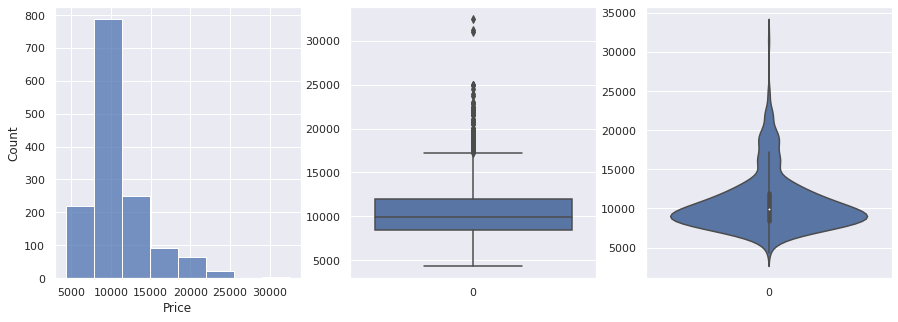

In [70]:
#Si modifico la variable price
graficar_info_variable(df.Price)

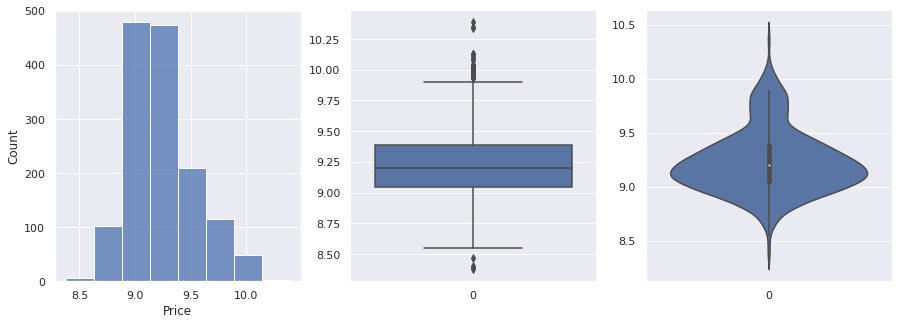

In [71]:
df.Price = np.log(df.Price)
graficar_info_variable(df.Price)

In [72]:
porcentaje_outliers(df.Price)

Porcentaje de outliers:  2.8551532033426184


In [73]:
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  1.6487455197132617


In [74]:
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  1.6034985422740524


In [18]:
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  0.0


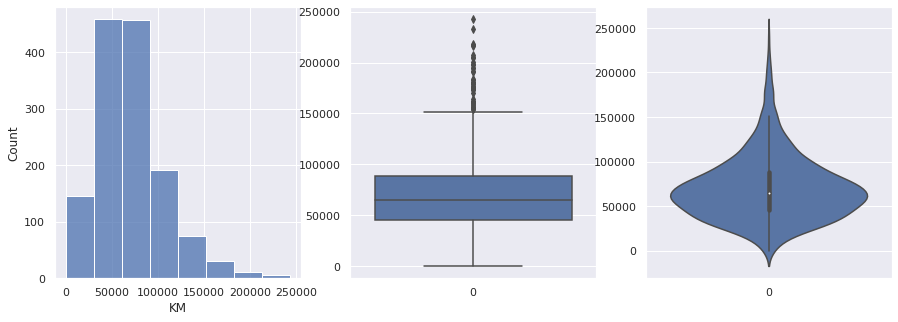

In [75]:
graficar_info_variable(df.KM)

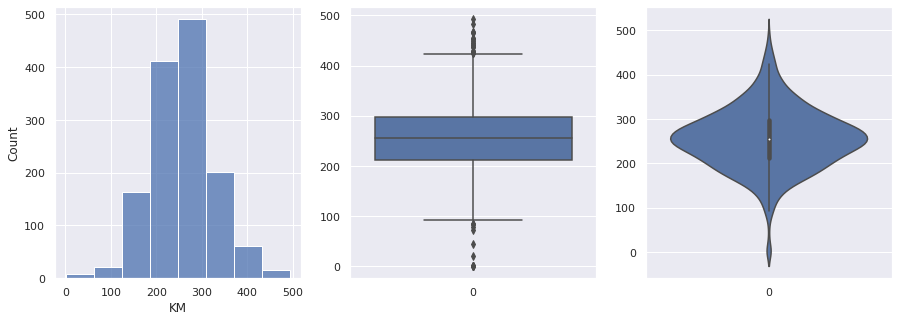

In [76]:
df.KM = np.sqrt(df.KM)
graficar_info_variable(df.KM)

In [77]:
porcentaje_outliers(df.KM)

Porcentaje de outliers:  2.478134110787172


In [78]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.672645739910314


In [79]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.0


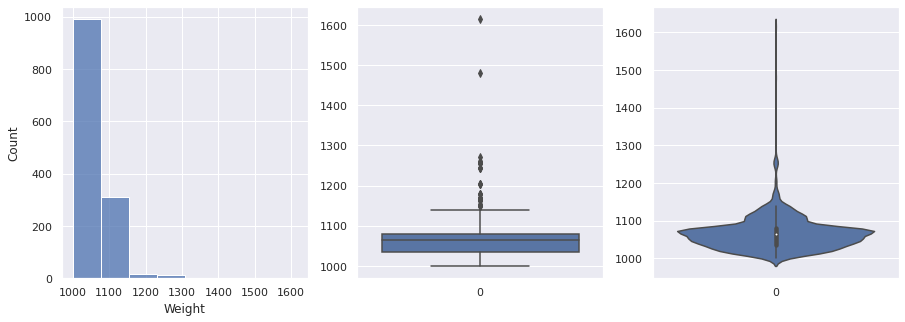

In [80]:
graficar_info_variable(df.Weight)

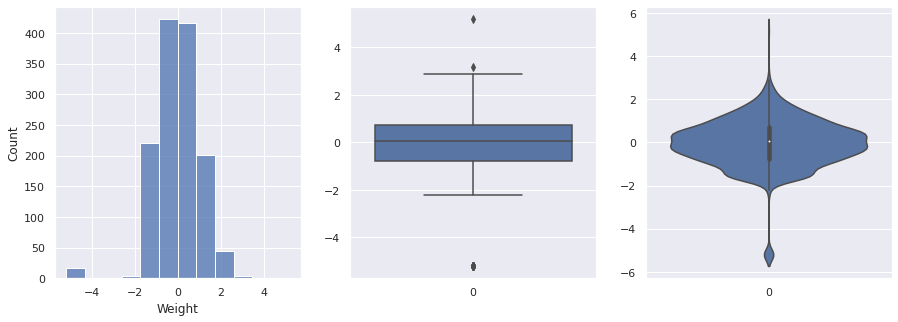

In [81]:
df.Weight = qt.fit_transform(df.Weight.values.reshape(-1, 1))
graficar_info_variable(df.Weight, 12)

In [82]:
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  1.3544018058690745


In [83]:
df = quitar_outliers(df, df.Weight)
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  0.0


#### Univariate Feature Selection

In [84]:
y = df.Price
x = df.drop(columns=['Price'])
names=pd.DataFrame(x.columns)

In [85]:
m = SelectKBest(score_func=f_regression, k=4)
r = m.fit(x, y)
results_df=pd.DataFrame(r.scores_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'], ascending = False)

,Feature,Score
2,Mfg_Year,4501.808197
0,Age_08_04,4077.958694
20,Boardcomputer,874.331121
3,KM,626.717487
11,Weight,345.854298
21,CD_Player,319.035191
18,Airco,293.202820
15,ABS,186.009444
19,Automatic_airco,168.393145
22,Central_Lock,141.542397


In [86]:
columns = ['Mfg_Year', 'Age_08_04', 'Boardcomputer','Automatic_airco', 'Weight', 'KM', 'CD_Player', 'Airco', 'Powered_Windows',
           'Central_Lock', 'HP', 'ABS', 'Price']

In [87]:
df = df[columns]

In [88]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [89]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
x.Mfg_Year = standar_scaler.fit_transform(x.Mfg_Year.values.reshape(-1, 1))
x.Age_08_04 = standar_scaler.fit_transform(x.Age_08_04.values.reshape(-1, 1))
x.HP = standar_scaler.fit_transform(x.HP.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

**ENTRENAR MODELO**

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.4105


In [91]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     426.9
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:37:24   Log-Likelihood:                -447.56
No. Observations:                 917   AIC:                             921.1
Df Residuals:                     904   BIC:                             983.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1742      0.038     -4.548      0.000      -0.249      -0.099
Mfg_Year            0.6294      0.066      9.559      0.000       0.500       0.759
Age_08_04          -0.0300      0.066     -0.457      0.648      -0.159       0.099
Boardcomputer      -0.0145      0.044     -0.333      0.739      -0.100       0.071
Automatic_airco     0.2485      0.079      3.140      0.002       0.093       0.404
Weight              0.1693      0.016     10.845      0.000       0.139       0.200
KM                 -0.2056      0.016    -12.629      0.000      -0.238      -0.174
CD_Player           0.0613      0.040      1.550      0.121      -0.016       0.139
Airco               0.1258      0.034      3.721      0.000       0.059       0.192
Powered_Windows     0.1311      0.058      2.261      0.024       0.017       0.245
Central_Lock        0.0233      0.058      0.402      0.688      -0.090       0.137
HP                  0.0197      0.014      1.390      0.165      -0.008       0.048
ABS                 0.0344      0.037      0.937      0.349      -0.038       0.106
==============================================================================
Omnibus:                       24.539   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.553
Skew:                          -0.191   Prob(JB):                     5.75e-10
Kurtosis:                       3.984   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
columns_final = ['Mfg_Year','Automatic_airco', 'Weight', 'KM', 'Airco','HP']

In [93]:
x_final = x[columns_final]

#### Guardar modelos mlflow

In [94]:
mlflow.set_tracking_uri('http://66.97.41.26:8080/')
experiment_name = "dataset_toyota_corolla"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(name=experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

##### Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [95]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    linear_regression = LinearRegression()
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    r2 = cross_val_score(linear_regression, x_final, y, scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x_final, y, scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    linear_regression.fit(x_final, y)
    signature = infer_signature(x_final, linear_regression.predict(x_final))
    mlflow.log_param("n_features", len(columns_final))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(linear_regression, "linear_regression_log_price", signature=signature)

/home/jose/miniconda3/envs/data/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [96]:
r2, rmse

(0.8349195044994188, 0.404838224861663)

##### Lasso

In [41]:
from sklearn.linear_model import LassoCV

In [42]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    lasso = LassoCV(cv=5, random_state=0)
    r2 = cross_val_score(lasso, x, y.ravel(), scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x, y.ravel(), scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    lasso.fit(x, y.ravel())
    signature = infer_signature(x, lasso.predict(x))
    mlflow.log_param("n_features", len(columns))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(lasso, "lasso_log_price", signature=signature)

/home/jose/miniconda3/envs/data/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [43]:
r2, rmse

(0.8447158490855389, 0.3927622735627775)

##### Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.2, random_state=42)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['1.0', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    random_forest_regressor = RandomForestRegressor()
    best_random_forest = RandomizedSearchCV(
        estimator = random_forest_regressor,
        param_distributions = random_grid,
        n_iter = 100,
        cv = 3,
        verbose=2,
        random_state=42,
        n_jobs = -1)
    best_random_forest.fit(x_train, y_train.ravel())
    r2 = best_random_forest.score(x_train, y_train)
    rmse = mean_squared_error(y_test, best_random_forest.predict(x_test), squared=False)
    signature = infer_signature(x_train, best_random_forest.predict(x_train))
    mlflow.log_param("n_features", len(columns_final))
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(random_forest_regressor, "random_forest_regressor_log_price", signature=signature)

In [ ]:
r2, rmse

(0.8928293826364772, 0.32044010430224285)

#### Aplicando PCA

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=7)
x_pca = pca.fit_transform(x)

##### Linear regression

In [47]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    linear_regression = LinearRegression()
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    r2 = cross_val_score(linear_regression, x_pca, y, scoring='r2', cv=folds).mean()
    mse = cross_val_score(linear_regression, x_pca, y, scoring='neg_mean_squared_error', cv=folds).mean()*-1
    rmse = math.sqrt(mse)
    linear_regression.fit(x_pca, y)
    signature = infer_signature(x_pca, linear_regression.predict(x_pca))
    mlflow.log_param("n_comp_pca", pca.n_components)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(linear_regression, "linear_regression_log_price", signature=signature)

In [48]:
r2, rmse

(0.8378738458168584, 0.40102207222498054)

##### Random Forest

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

In [ ]:
with mlflow.start_run(experiment_id = experiment.experiment_id):
    random_forest_regressor = RandomForestRegressor()
    best_random_forest = RandomizedSearchCV(
        estimator = random_forest_regressor,
        param_distributions = random_grid,
        n_iter = 100,
        cv = 3,
        verbose=2,
        random_state=42,
        n_jobs = -1)
    best_random_forest.fit(x_train, y_train.ravel())
    r2 = best_random_forest.score(x_train, y_train)
    rmse = mean_squared_error(y_test, best_random_forest.predict(x_test), squared=False)
    signature = infer_signature(x_train, best_random_forest.predict(x_train))
    mlflow.log_param("n_comp_pca", pca.n_components)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(random_forest_regressor, "random_forest_regressor_log_price", signature=signature)

In [ ]:
r2, rmse

(0.9369435071576129, 0.33511305452253554)

**GRAFICAS**

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.4093


In [98]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     831.3
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:37:57   Log-Likelihood:                -460.53
No. Observations:                 917   AIC:                             935.1
Df Residuals:                     910   BIC:                             968.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0948      0.020     -4.842      0.000      -0.133      -0.056
Mfg_Year            0.6704      0.018     37.684      0.000       0.636       0.705
Automatic_airco     0.2572      0.080      3.220      0.001       0.100       0.414
Weight              0.1720      0.016     11.029      0.000       0.141       0.203
KM                 -0.2043      0.016    -12.530      0.000      -0.236      -0.172
Airco               0.2089      0.030      7.046      0.000       0.151       0.267
HP                  0.0301      0.014      2.154      0.031       0.003       0.058
==============================================================================
Omnibus:                       22.968   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.228
Skew:                          -0.231   Prob(JB):                     3.69e-08
Kurtosis:                       3.826   Cond. No.                         8.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

In [100]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:ylabel='Count'>

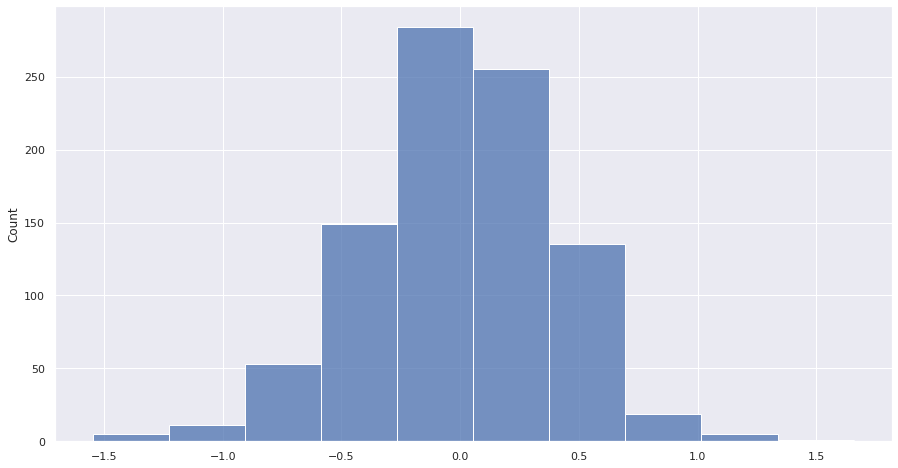

In [101]:
# Residuales
sns.histplot(ml_results.resid, bins=10)

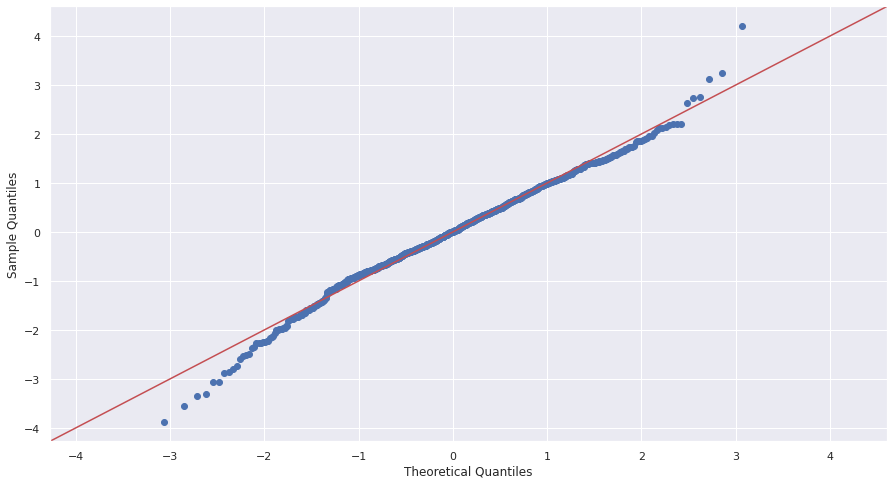

In [102]:
def grafico_qqplot():
    fig = sm.qqplot(lm_resid_stand,line='45')
    plt.show()

grafico_qqplot()

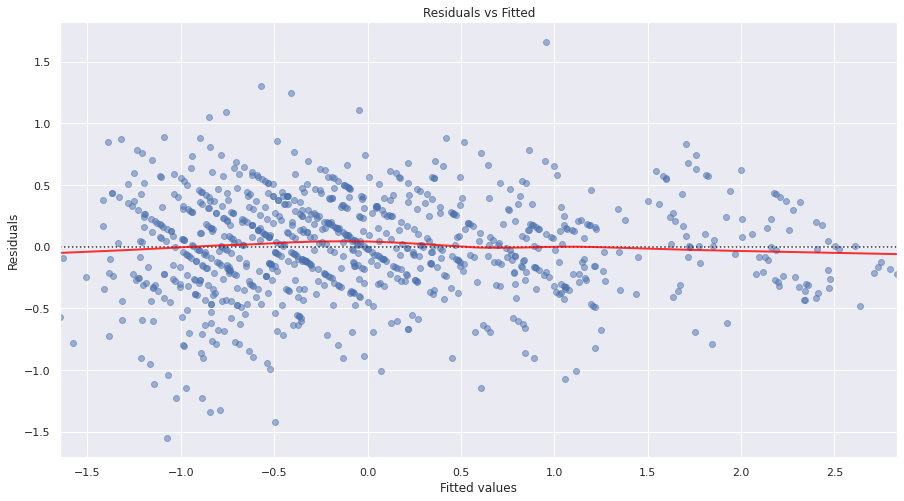

In [103]:
def residuales_vs_ajustados():
    plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                         scatter_kws={'alpha': 0.5},
                         line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

    # Titel and labels
    plot.set_title('Residuals vs Fitted')
    plot.set_xlabel('Fitted values')
    plot.set_ylabel('Residuals')
residuales_vs_ajustados()